# Lecture 13-supp - Kernel Density Estimation (KDE)

In [1]:
import scipy.stats as stats
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('bmh')

# More on Histograms for Data from Continuous Random Variables

* **What if we do not know which distribution shape a sample was drawn from?**

* **Can we estimate a PDF from the sample data?**

Consider the following observational data:

In [2]:
E=stats.expon()
G=stats.norm()

In [3]:
g=np.linspace(-5,5,101)
e=np.linspace(0,10,101)

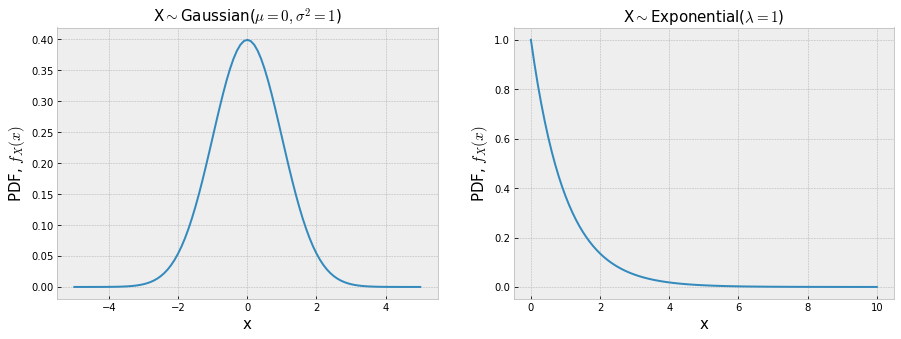

In [4]:
fig=plt.figure(figsize=(15,5))
fig.add_subplot(1,2,1)
plt.plot(g,G.pdf(g))
plt.title('X$\sim$Gaussian($\mu=0,\sigma^2=1$)',size=15)
plt.ylabel('PDF, $f_X(x)$',size=15)
plt.xlabel('x',size=15)

fig.add_subplot(1,2,2)
plt.plot(e,E.pdf(e))
plt.title('X$\sim$Exponential($\lambda=1$)',size=15)
plt.ylabel('PDF, $f_X(x)$',size=15)
plt.xlabel('x',size=15);

Let's draw some observations from both random variables and try to understand how the histogram of the observations relates to the densities:

In [5]:
Evals=E.rvs(size=100)
Gvals=G.rvs(size=100)

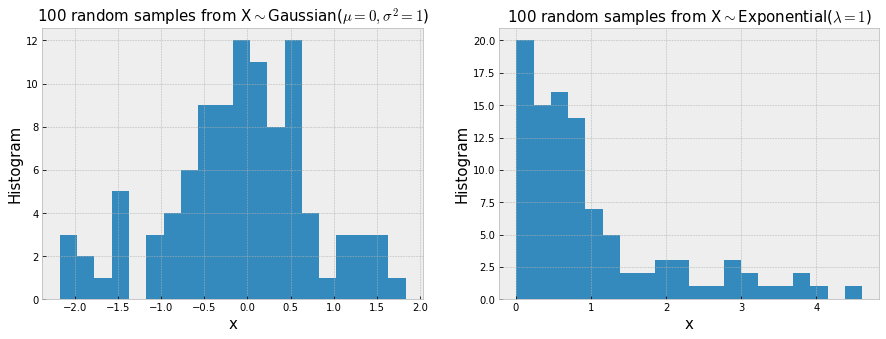

In [6]:
fig=plt.figure(figsize=(15,5))
fig.add_subplot(1,2,1)
plt.hist(Gvals, bins=20)
plt.title('100 random samples from X$\sim$Gaussian($\mu=0,\sigma^2=1$)',size=15)
plt.ylabel('Histogram',size=15)
plt.xlabel('x',size=15)

fig.add_subplot(1,2,2)
plt.hist(Evals, bins=20)
plt.title('100 random samples from X$\sim$Exponential($\lambda=1$)',size=15)
plt.ylabel('Histogram',size=15)
plt.xlabel('x',size=15);

We note from the graphs that the histograms have the same general shape as the densities for these random variables. 

Let's see why this is true: 

Let $X$ be a random variable with density $f_X(x)$. 

Now consider a bin $(x_1,x_2]$ over which the density $f_X(x)$ is continuous. Then there is $\tilde{x} \in (x_1, x_2]$ such that
\begin{align}
P \bigl( X \in  \left(x_1,x_2\right] \bigr) &= \int_{x_1}^{x_2} f_X(x)~dx \\
&= f_X(\tilde{x})(x_2-x_1)
\end{align}

Thus, the probability of a point lying in a bin is proportional to a density value in that bin and the width of the bin

We could turn the histogram into estimates of the bin probabilities by dividing all the entries by the total number of observations

Let $N$ denote the total number of observations. Let $B_i=(x_i, x_{i+1}]$ denote bin $i$, and $N_i$ denote the number of observations that fall in $B_i$, then 
$$
P \bigl( X \in  B_i) \approx \frac{N_i}{N}
$$

However, it makes more sense for our purposes to divide by a factor to get estimates of the density instead



Looking at the equation 
\begin{align}
P \bigl( X \in  \left(x_1,x_2\right] \bigr)
&= f_X(\tilde{x})(x_2-x_1),
\end{align}
we can approximate the density in bin $i$ by
$$
f_X(\tilde{x_i}) \approx \frac{N_i}{N \vert B_i \vert}
$$

Let's test. To make it easier to see, let's use bins with edges on the integers:

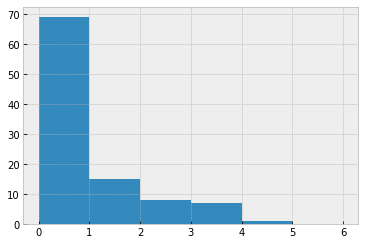

In [7]:
mybins=range(7)
counts,bins,_=plt.hist(Evals,bins=mybins)

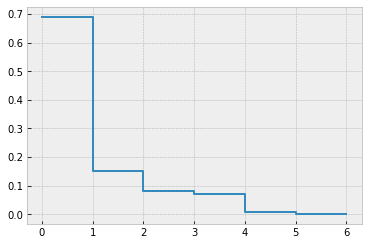

In [8]:
plt.step(bins,np.append(counts,0)/(np.sum(counts)*(bins[1]-bins[0])),where='post');

Let's check if that is a valid density:

In [9]:
np.sum(np.append(counts,0)/np.sum(counts)/(bins[1]-bins[0]))

1.0

Fortunately for us, we don't have to remember this formula or derive it whenever we want to create estimates of densities using a histogram from matplotlib.

Instead just call ```plt.hist``` with the keyword argument ```density=True```

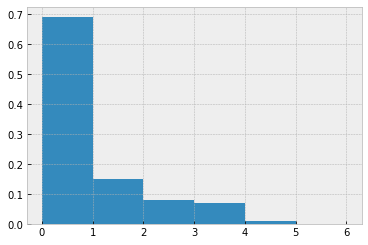

In [10]:
plt.hist(Evals, mybins, density=True);

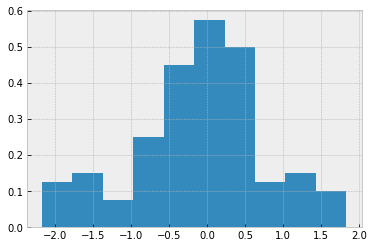

In [11]:
plt.hist(Gvals, density=True);

# Kernel Density Estimation

We have solved one of the problems in using histograms to approximate densities. 

But another problem remains: the blocky histogram does a poor job of approximating a continuous density.

We can increase the number of bins to get a finer resolution, but then the number of observations in each bin get smaller, and the approximations for the density values may become poor:

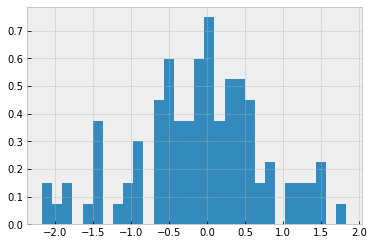

In [12]:
counts,bins,_=plt.hist(Gvals,bins=30, density=True);

Recall that we can build a histogram by putting a block for each observation, where the blocks are centered on the bins. 

We can use animation to visualize this better.  Because the animation is slow, let's use 40 random variables instead of 100:


In [13]:
G40=G.rvs(size=40)

<IPython.core.display.Javascript object>


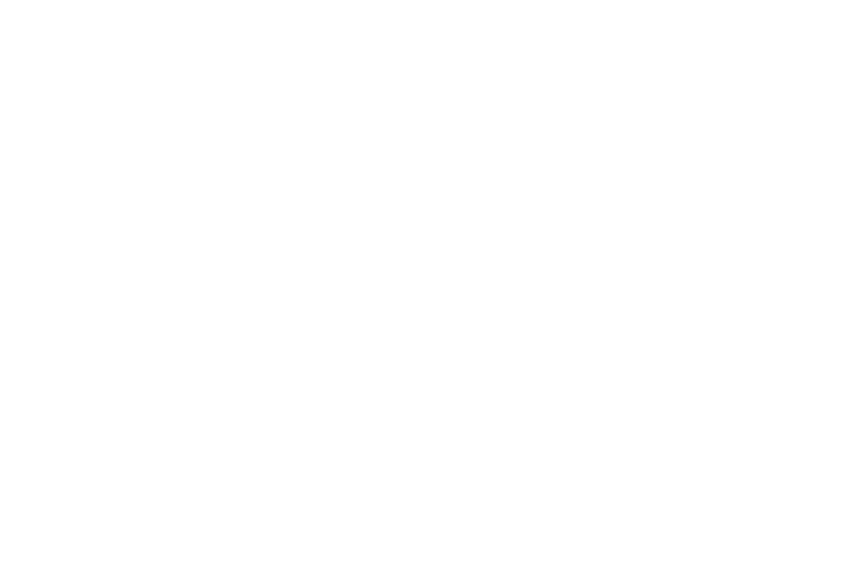

In [14]:
from matplotlib import animation
#This will do an animated histogram
%matplotlib notebook

fig = plt.figure()
fig.set_dpi(100)
fig.set_size_inches(5, 4)
ymax=10

ax = plt.axes(xlim=(-3, 3), ylim=(0, ymax))
patches={}
floors={}

def init():
    patches['activePatch']=0
    for num,var in enumerate(G40):
        binedge=(var*2-0.5).round()/2
        patch = plt.Rectangle((binedge, ymax), 0.5,0.5, fc='b')
        ax.add_patch(patch)
        patches[num]=patch
        floors[binedge]=0.01
        #print(num,var, patches)


    return []

def animatePatch(i, patch, update):
    x, y = patch.xy
    #x = 2*patchnum + 3 * np.sin(np.radians(i))
    if update:
        y =  y-0.5
    patch.xy = (x, y)
    return patch,

def animate(i, patches):
    activePatch=patches['activePatch']
    x,y=patches[activePatch].xy
    if y<=floors[x]:
        floors[x]=floors[x]+0.5
        patches['activePatch']=activePatch+1
        activePatch+=1
        if activePatch not in patches.keys():
            return []
    #print(patches[activePatch])
    for patchnum in patches:
        #print(patchnum)
        if patchnum!='activePatch':
            animatePatch(i, patches[patchnum], activePatch==patchnum)
    
    return[]

anim = animation.FuncAnimation(fig, animate, 
                               init_func=init, 
                               frames=10*len(G40), 
                               fargs=(patches,),
                               interval=5,
                               blit=True,repeat=False)

plt.show()


What if we instead let each block be centered on the observation value?

Blocks don't stack neatly now, so we allow each part of the block to fall to the lowest open level:

<IPython.core.display.Javascript object>


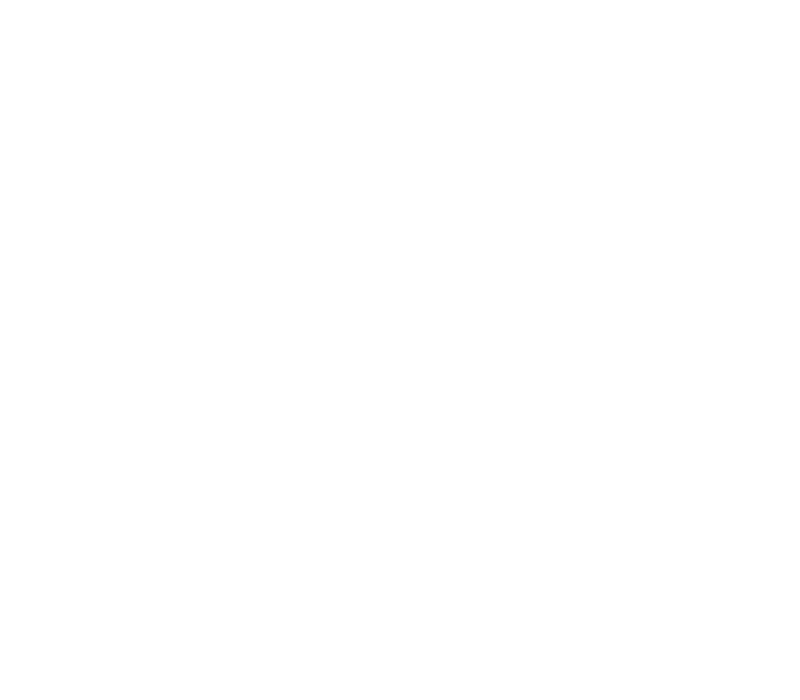

In [15]:
# Now center blocks on the observed values
# Quantizing the space to make this work out
%matplotlib notebook


fig = plt.figure()
fig.set_dpi(100)
fig.set_size_inches(4, 3.5)

ax = plt.axes(xlim=(-5, 5), ylim=(0, 10))
blocks={}
floors={}
patchesPerBlock=9

def init():
    blocks['activeBlock']=0
    for num,var in enumerate(G40):
        center=round(var,1)
        blocks[num]=[]
        for i in range(patchesPerBlock):
            binedge=round(center+(i-patchesPerBlock//2)*0.1,1)
            patch = plt.Rectangle((binedge, 10), 0.1,0.5, fc='b')
            ax.add_patch(patch)
            blocks[num]+=[patch]
            floors[binedge]=0.01
        #print(num,var, patches)


    return []

def animatePatch(i, patch,update):
    return patch,

def animate(i, blocks):
    activeBlock=blocks['activeBlock']
    #print(activeBlock,blocks)
    numFloored=0
    for patch in blocks[activeBlock]:
        x,y=patch.xy
        if y<=floors[x]:
            #floors[x]=floors[x]+0.6
            #print("floors[",x,"]=",floors[x])
            numFloored+=1
        else:
            x,y=patch.xy
            patch.xy=(x,y-0.5)
    if numFloored>=patchesPerBlock:
        for patch in blocks[activeBlock]:
            x,y=patch.xy
            floors[x]=floors[x]+0.5
        blocks['activeBlock']=activeBlock+1
        activeBlock+=1
        if activeBlock not in blocks.keys():
            return []
        #print(patches[activePatch])
    for i in blocks:
        #print(patchnum)
        if i!='activeBlock':
            for patch in blocks[i]:
                animatePatch(i, patch,activeBlock==i)

    return[]

anim = animation.FuncAnimation(fig, animate, 
                               init_func=init, 
                               frames=100*len(G40), 
                               fargs=(blocks,),
                               interval=5,
                               blit=True,repeat=False)

plt.show()

This seems much closer to the true density. Here is a similar (non-animated) graph for 100 Gaussian RVs, with a finer quantization:

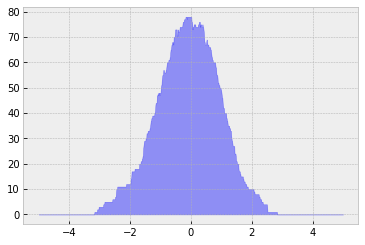

In [16]:
%matplotlib inline
x = np.linspace(-5, 5, 1000)
width=2
density=np.zeros(x.size)
for xi in Gvals:
    block=(x>xi-width/2)&(x< xi+width/2)
    density+=block
plt.fill_between(x,density, color='b', alpha=0.4);

This is better, but not very smooth. There is no reason to only use rectangular blocks, so let's try a smoother shape.

In the animation below, I have replaced the rectangular block with a Gaussian shape (known as *Gaussian kernel*).

This is even slower than the previous animations, so let's reduce down to 25 variables:

In [17]:
G25=stats.norm.rvs(size=25)

<IPython.core.display.Javascript object>


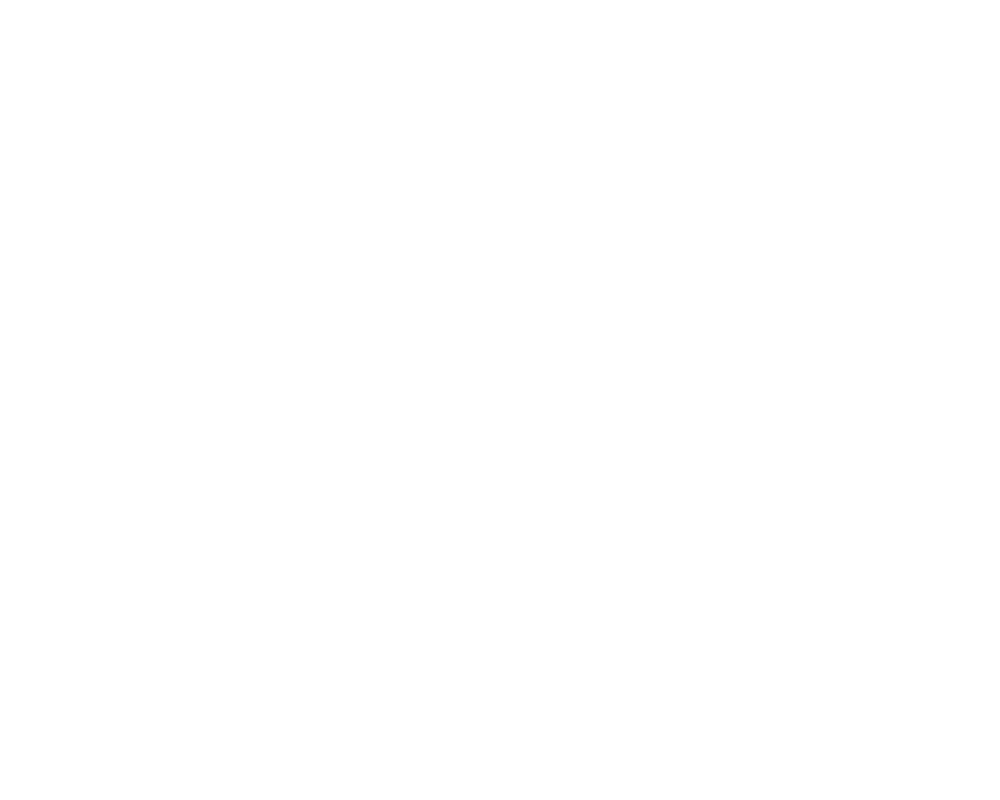

In [18]:
# Trying to use non-rectangular shape
%matplotlib notebook

fig = plt.figure()
fig.set_dpi(100)
fig.set_size_inches(5, 4)

ax = plt.axes(xlim=(-5, 5), ylim=(0, 15))
blocks={}
floors={}
patchesPerBlock=25

def init():
    blocks['activeBlock']=0
    for num,var in enumerate(G25):
        center=round(var,1)
        blocks[num]=[]
        for i in range(patchesPerBlock):
            binedge=round(center+(i-patchesPerBlock//2)*0.1,1)
            patch = plt.Rectangle((binedge, 16), 0.1,
                                  stats.norm.pdf((i-patchesPerBlock//2)*0.1,scale=0.5)*1.5, fc='b')
            ax.add_patch(patch)
            blocks[num]+=[patch]
            floors[binedge]=0.01
        #print(num,var, patches)


    return []

def animatePatch(i, patch,update):
    return patch,

def animate(i, blocks):
    activeBlock=blocks['activeBlock']
    #print(activeBlock,blocks)
    numFloored=0
    for patch in blocks[activeBlock]:
        x,y=patch.xy
        if y<=floors[x]:
            #floors[x]=floors[x]+0.6
            #print("floors[",x,"]=",floors[x])
            patch.xy=(x,floors[x])
            numFloored+=1
        else:
            patch.xy=(x,y-0.2)
    if numFloored>=patchesPerBlock:
        for patch in blocks[activeBlock]:
            x,y=patch.xy
            floors[x]=round(floors[x]+patch.get_height(),1)
        blocks['activeBlock']=activeBlock+1
        activeBlock+=1
        if activeBlock not in blocks.keys():
            return []
        #print(patches[activePatch])
    for i in blocks:
        #print(patchnum)
        if i!='activeBlock':
            for patch in blocks[i]:
                animatePatch(i, patch,activeBlock==i)

    return[]

anim = animation.FuncAnimation(fig, animate, 
                               init_func=init, 
                               frames=100*len(G25), 
                               fargs=(blocks,),
                               interval=5,
                               blit=True,repeat=False)
anim
plt.show()

Here is the same type of graph created with a wider, more finely quantized Gaussian shape and 100 Gaussian random variables:

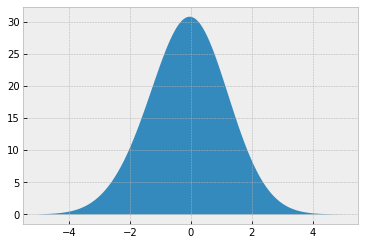

In [19]:
%matplotlib inline
x = np.linspace(-5,5, 1000)
density=np.zeros(x.size)
for xi in Gvals:
    ## Create new Gaussian RVs centered on the observation
    Gi=stats.norm(xi) 
    ## Use the density of the RV as the shape instead of a block:
    density+=Gi.pdf(x) 
    
plt.fill_between(x, density);

## Kernel Density Estimation (KDE)

**Magic!** This looks a lot like our density, even though we only had 100 observations!

The shape we use to build this new density estimate is called a **"kernel"**.

This approach is called **kernel density estimation (KDE)**.

However things are not quite as good as they seem:

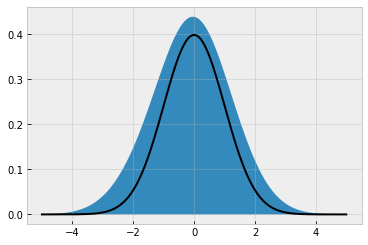

In [20]:
x = np.linspace(-5,5, 1000)
density=np.zeros(x.size)
for xi in Gvals:
    ## Create new Gaussian RVs centered on the observation
    Gi=stats.norm(xi) 
    ## Use the density of the RV as the shape instead of a block:
    density+=Gi.pdf(x) 
    
plt.fill_between(x,density/70) #Scale to make amplitudes match
plt.plot(x, G.pdf(x),'k');

Why? We only have 100 data points.

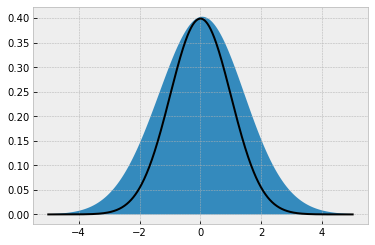

In [21]:
Gvals2=G.rvs(size=1000)
x = np.linspace(-5,5, 1000)
density=np.zeros(x.size)
for xi in Gvals2:
    ## Create new Gaussian RVs centered on the observation
    Gi=stats.norm(xi) 
    ## Use the density of the RV as the shape instead of a block:
    density+=Gi.pdf(x) 
    
plt.fill_between(x,density/700) #Scale to make amplitudes match
plt.plot(x, G.pdf(x),'k');

The esimated density is still wider than the true density. This is because the kernel we are using is too wide to capture the true density -- it provides too much smoothing. Let's try a narrower kernel:

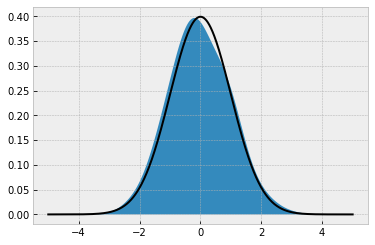

In [22]:
Gvals2=G.rvs(size=1000)
x = np.linspace(-5,5, 1000)
density=np.zeros(x.size)
for xi in Gvals2:
    ## Create new Gaussian RVs centered on the observation
    Gi=stats.norm(xi,scale=0.4) 
    ## Use the density of the RV as the shape instead of a block:
    density+=Gi.pdf(x) 
    
plt.fill_between(x,density/950) #Scale to make amplitudes match
plt.plot(x, G.pdf(x),'k');

That is pretty close. 

So one important issue in KDE is choosing the appropriate kernel.

The Gaussian kernel is most common, but the variance of the kernel must be chosen appropriately (this is also known as the kernel **bandwidth**).

Let's try some other variances:

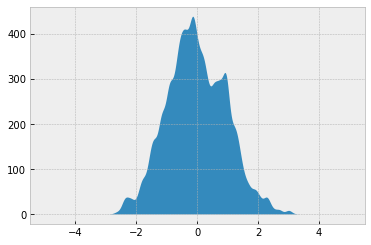

In [23]:
x = np.linspace(-5,5, 1000)
density=np.zeros(x.size)
for xi in Gvals2:
    ## Create new Gaussian RVs centered on the observation
    Gi=stats.norm(xi,scale=0.1) 
    ## Use the density of the RV as the shape instead of a block:
    density+=Gi.pdf(x) 
    
plt.fill_between(x,density);

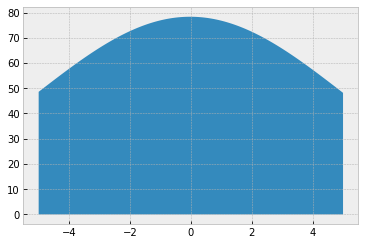

In [24]:
x = np.linspace(-5,5, 1000)
density=np.zeros(x.size)
for xi in Gvals2:
    ## Create new Gaussian RVs centered on the observation
    Gi=stats.norm(xi,scale=5) 
    ## Use the density of the RV as the shape instead of a block:
    density+=Gi.pdf(x) 
    
plt.fill_between(x,density);

Let's try an **exponential kernel**:

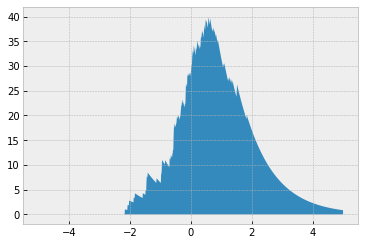

In [25]:
x = np.linspace(-5,5, 1000)
density=np.zeros(x.size)
for xi in Gvals:
    ## Create new exponential RVs centered on the observation
    Ei=stats.expon(xi) 
    ## Use the density of the RV as the shape instead of a block:
    density+=Ei.pdf(x) 
    
plt.fill_between(x,density);

It is not that bad, but way worse than our Gaussian kernel.

Now consider applying KDE to the observations from the Exponential random variable:

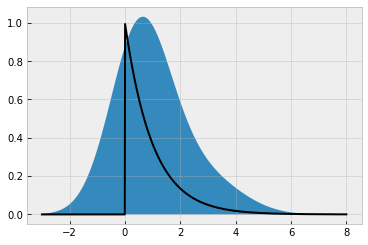

In [26]:
x = np.linspace(-3,8, 1000)
density=np.zeros(x.size)
for xi in Evals:
    Gi=stats.norm(xi)
    density+=Gi.pdf(x)
plt.fill_between(x,density/30)
plt.plot(x, E.pdf(x),'k');

Hmmm.... That doesn't look like an exponential density. Our random variable is non-negative!!!

We could do a little better if we make our shape more narrow:

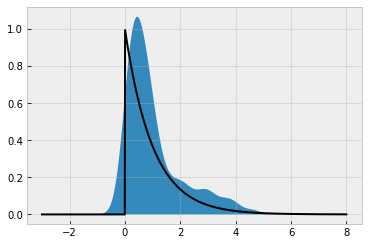

In [27]:
x = np.linspace(-3,8, 1000)
density=np.zeros(x.size)
for xi in Evals:
    Gi=stats.norm(xi,scale=0.3)
    density+=Gi.pdf(x)
plt.fill_between(x,density/60)
plt.plot(x, E.pdf(x),'k');

Finally, let's try our exponential kernel:

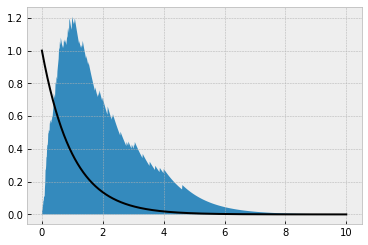

In [28]:
x = np.linspace(0, 10, 1000)
density=np.zeros(x.size)
for xi in Evals:
    ## Create new exponential RVs centered on the observation
    Ei=stats.expon(xi) 
    ## Use the density of the RV as the shape instead of a block:
    density+=Ei.pdf(x) 
    
plt.fill_between(x,density/35)
plt.plot(x, E.pdf(x),'k');

Well, it is non-negative, but still not great

One, more time with a narrower kernel:

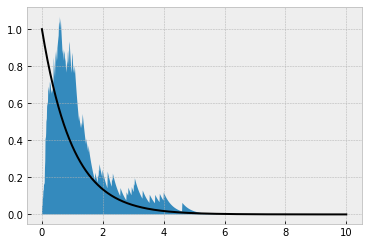

In [29]:
x = np.linspace(0, 10, 1000)
density=np.zeros(x.size)
for xi in Evals:
    ## Create new exponential RVs centered on the observation
    Ei=stats.expon(xi,scale=0.3) 
    ## Use the density of the RV as the shape instead of a block:
    density+=Ei.pdf(x) 
    
plt.fill_between(x,density/70)
plt.plot(x, E.pdf(x),'k');

It is very hard to get a good estimate because the Exponential density is not continuous.

In this class, we will apply KDE to continuous densities, and we will always use the Gaussian kernel.

However, we still need to choose the variance of the kernel.

Fortunately, there are techniques to automatically choose the variance of the Gaussian kernel. 

We will generally use scipy.stat's gaussian_kde method, which uses a heuristic to choose the variance of the Gaussian kernel (called the bandwidth)


In [30]:
Gkde=stats.gaussian_kde(Gvals2)

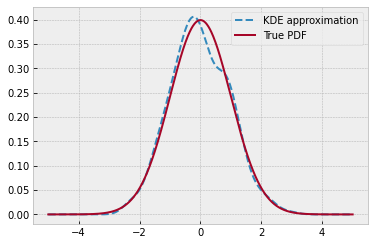

In [31]:
x=np.linspace(-5,5,1001)
plt.plot(x,Gkde(x), '--',label='KDE approximation')
plt.plot(x,G.pdf(x), label='True PDF')
plt.legend();

## Summary

**Kernel density estimation (KDE)** is a non-parametric estimator of probability density function (pdf) of a random variable. It is a fundamental data smoothing problem where inferences about the population are made, based on a finite data sample. It uses a mixture consisting of a Kernel component centered at each data point.

* A density estimator is an algorithm which seeks to model the probability distribution that generated a data set. For one dimensional data, you are already familiar with one simple density estimator: the histogram. A histogram divides the data into discrete bins, counts the number of points that fall in each bin, and then visualizes the results in an intuitive manner.

* One of the issues with using a histogram as a density estimator is that the choice of bin size and location can lead to representations that have qualitatively different features. 

* In order to smooth them out, we might decide to replace the blocks at each location with a smooth function, like a Gaussian. 

* The free parameters of kernel density estimation are the *kernel*, which specifies the shape of the distribution placed at each point, and the kernel *bandwidth*, which controls the size of the kernel at each point. In practice, there are many kernels you might use for a kernel density estimation: in particular, the Scikit-Learn KDE implementation supports six kernel functions, which you can read about in Scikit-Learn's [Density Estimation documentation](https://scikit-learn.org/stable/modules/density.html).